In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score, classification_report
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import model.gman.model1 as gman
from utils import metrics
from utils.loaders.dataset import load_dataset
from utils.loaders.loaders import load_SE
from model.blackBox.graphWavenet.wrapper import BlackBox
from utils.pertubate import Gaussian

In [1]:
import pandas as pd

df = pd.read_hdf('data/METR-LA/data.h5')
df.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


In [2]:
df.shape

(34272, 207)

In [3]:
def evaluate(testY, testYm):
    testY = testY.detach().cpu().numpy().ravel()
    testYm = testYm.detach().cpu().numpy().ravel()
    # Tính AUC-PRC
    auc_prc = average_precision_score(testY, testYm, average='macro')
    report = classification_report(testY, np.round(testYm), output_dict=True, zero_division=0)

    recall = report["macro avg"]["recall"]
    precision = report["macro avg"]["precision"]
    
    correct_label = np.sum(np.round(testYm) == testY)

    return auc_prc, recall, precision, correct_label

In [7]:
def read_log(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    loss_values = []
    for line in lines:
        values = line.strip().split(',')
        if len(values) >= 2:
            training_loss = float(values[1].strip().split(':')[-1].strip())
            loss_values.append(training_loss)
    return loss_values


def saliency(heatmap):
    cmap = plt.cm.colors.ListedColormap(['lightpink', '#00CCFF'])
    bounds = [0, 0.5, 1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    plt.close('all')
    fig = plt.figure(figsize=(12, 4))
    a = plt.imshow(heatmap, cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    _ = plt.xlabel("time steps")
    _ = plt.ylabel("nodes")
    _ = plt.tight_layout()
    cbar = plt.colorbar(a, ticks=[0.25, 0.75])
    cbar.set_ticklabels(['False', 'True'])
    
    
    
def visualization_loss(train, val, test): 
    epochs = list(range(1, len(train) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train, label='Training Loss', marker='o')
    plt.plot(epochs, val, label='Validation Loss', marker='o')
    plt.plot(epochs, test, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Validation and Test Loss')
    plt.legend()
    plt.grid(True)
    
def main(path): 
    fix_seed = 42
    # random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)

    class Args():
        def __init__(self):
            self.mode = "Train"
            self.device = 'cuda:0'
            # loaders
            self.data_dir = 'data/METR-LA'
            self.blackbox_data_dir = 'data/pretrained/GraphWavenet'
            self.adj_file = 'data/adj_mx.pkl'
            self.log_dir = 'log'
            self.save_dir = 'saved_models'
            # trainer
            self.batch_size = 13
            self.epochs = 2
            # optimizer
            self.weight_decay = 0.0001
            self.learning_rate = 0.001
            self.bn_decay = 0.1
            self.num_nodes = 207
            self.threshold = 0.5
            
            # patchTST
            self.seq_len = 12
            self.pred_len = 12
            self.patch_len = 1
            self.stride = 1

    args = Args()
    device = torch.device(args.device)

    data_loader = load_dataset(args.data_dir, args.batch_size)
    SE = load_SE(args.data_dir)
    scaler = data_loader['scaler']
    model = torch.load(path)
    
    
    heatmap = None
    n = 5
        
    data_loader['test_loader'].shuffle()
    for i, (x, y, t) in enumerate(data_loader['test_loader'].get_iterator()):
        # gman
        testX = torch.FloatTensor(np.expand_dims(x, axis=-1)).to(device)
        testY = torch.FloatTensor(np.expand_dims(y, axis=-1)).to(device)
        testTE = torch.FloatTensor(t).to(device)
        
        testY = (testY > args.threshold).float()
        output = model(testX, testTE)
        
        # PatchTST
        # trainX = torch.FloatTensor(x).to(device)
        # trainY = torch.FloatTensor(y).to(device)
        # output = model(trainX)
        predY = scaler.inverse_transform(output)
        auc_prc, recall, precision, correct_label = evaluate(testY, predY)
        print("---------------------------")
        print(f"AUC-PRC: {auc_prc}")
        print(f"Recall (Macro Avg): {recall}")
        print(f"Precision (Macro Avg): {precision}")
        print(f"Correct Labels: {correct_label}")
        
        h = output[0].squeeze(0).squeeze(-1).detach().cpu().numpy().T
        if heatmap is None:
            heatmap = h
        else:
            heatmap = np.concatenate((heatmap, h), axis=1)
        # print(f'batch {i + 1}: done')
        if i == n - 1:
            break
        
    return heatmap
        

In [8]:
heatmap = main('saved_models/G_T_model_2.pth')

Num_vertex:  207
Dimentions:  64
---------------------------
AUC-PRC: 0.8463483944665249
Recall (Macro Avg): 0.0
Precision (Macro Avg): 0.0
Correct Labels: 0
---------------------------
AUC-PRC: 0.8830374492007126
Recall (Macro Avg): 0.0
Precision (Macro Avg): 0.0
Correct Labels: 0
---------------------------
AUC-PRC: 0.8963776147990927
Recall (Macro Avg): 0.0
Precision (Macro Avg): 0.0
Correct Labels: 0
---------------------------
AUC-PRC: 0.8842093398766602
Recall (Macro Avg): 0.0
Precision (Macro Avg): 0.0
Correct Labels: 0
---------------------------
AUC-PRC: 0.9245366474608986
Recall (Macro Avg): 0.0
Precision (Macro Avg): 0.0
Correct Labels: 0


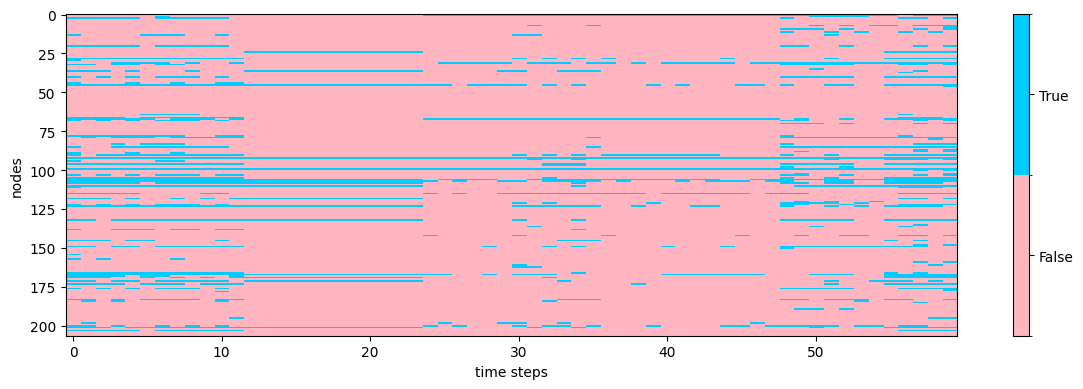

In [6]:
saliency(heatmap)

In [ ]:
training_loss_values = read_log('Loss_G_T//loss_train_log.txt')
val_loss_values = read_log('Loss_G_T//loss_val_log_G_T.txt')
test_loss_values = read_log('Loss_G_T//loss_test_log_G_T.txt')
visualization_loss(training_loss_values, val_loss_values, test_loss_values)